<br>
<center><font size = 10> MSE 비교, Lasso Coeff , Cubic Spline 시각화  </font></center>
<br>

<br>
<br>
<br>
<br>
<br>
<br>


<div style = "width : 400px; paddig-right:10px; float : right;">
    <font size = 8>
        190531 이성령
    </font></div>





## Library Load

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import  Lasso , LassoCV , LinearRegression
import numpy.polynomial.polynomial as poly
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error , r2_score
import pandas as pd
from multiprocessing import Pool
import seaborn as sns
import pandas as pd , re , warnings
warnings.filterwarnings(action='ignore') 
np.random.seed(1234)

## Part-1


$y_i \sim N(0,1) (i=1,2,3...,n)$ <br>
$x_{ij} \sim N(0,1) j = 1,...,p$ <br>
$y_i = \beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip} + \epsilon_i$ <br>
<br>
train mse와 test mse 비교해보기!

In [3]:
def generate_x(variable_n  , size ) :
    total = np.random.normal(loc = 0 , scale = 1.0 , size = (size,) )[:,np.newaxis]
    for _ in np.arange(variable_n-1) :
        column = np.random.normal(loc = 0 , scale = 1.0 , size = (size) )[:,np.newaxis]
        total = np.concatenate( (total , column) , axis = 1)
    return total
train_n = 20
test_n = 10000
train_eps = np.random.normal(loc = 0 , scale = 0.1 , size = (train_n , ) )[:,np.newaxis]
y = np.random.normal(loc = 0 , scale = 1.0 , size = (train_n , ) )[:,np.newaxis] + train_eps
X = generate_x(20,train_n)
test_eps = np.random.normal(loc = 0 , scale = 0.1 , size = (test_n , ) )[:,np.newaxis]
test_y = np.random.normal(loc = 0 , scale = 1.0 , size = (test_n , ) )[:,np.newaxis] + test_eps
test_X = generate_x(20,test_n)

In [6]:
train_mse = []
test_mse = []
R2 = []
variable = np.arange(1,21)
for i in variable :
    reg = LinearRegression(normalize=True , n_jobs= 10).fit(X[:,0:i] , y )
    train_mse.append(mean_squared_error(reg.predict(X[:,0:i]) , y))
    R2.append(reg.score(X[:,0:i] , y ))
    test_mse.append(mean_squared_error(reg.predict(test_X[:,0:i]) , test_y))


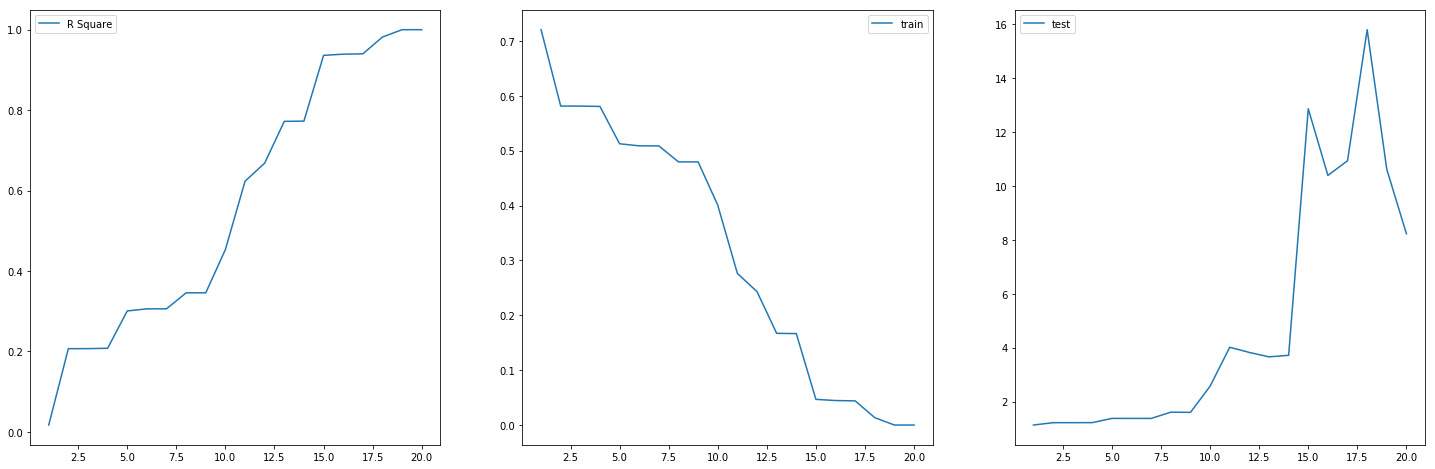

In [7]:
fig ,ax = plt.subplots(1,3, figsize = (25,8))
axx = ax.flatten()

OutCome = [R2 , train_mse, test_mse]
naming = ["R Square" , "train", "test"]
for idx , sub in enumerate(axx) :
    sub.plot(variable , OutCome[idx] , label = naming[idx])
    sub.legend()
plt.show()

## Part-2


In [231]:
def generate_x(variable_n  , size ) :
    total = np.random.uniform(low = -1.0 , high = 1.0 , size = (size,))[:,np.newaxis]
    for _ in np.arange(variable_n-1) :
        column = np.random.uniform(low = -1.0 , high = 1.0 , size = (size,))[:,np.newaxis]
        total = np.concatenate( (total , column) , axis = 1)
    return total

In [232]:
Lasso_CV = LassoCV(n_jobs=10 , random_state= 1234 ,normalize=True ,fit_intercept=True)
train_n = 100
train_eps = np.random.normal(loc = 0 , scale = 0.1 , size = (train_n , ) )
Freedom_X = generate_x(20  , train_n )
true_y = np.sum( Freedom_X ,axis = 1)  + train_eps
Lasso_CV.fit(Freedom_X , true_y)
best_alpha = Lasso_CV.alpha_
Degree_store = {}
Degree = [5 , 20,50,2000]
for i in Degree :
    print(i)
    store = []
    for _ in range(500) :
        Freedom_X = generate_x(i  , train_n )
        reg = Lasso(alpha = best_alpha, fit_intercept=True ,
                    normalize=True).fit(Freedom_X , true_y)
        store.append( sum(reg.coef_ != 0.0) )
    Degree_store[str(i)] = store

5
20
50
2000


In [233]:
Free = list(np.repeat([5,20,50,2000], 500 , axis = 0))
coef2 = list(np.squeeze(np.array([Degree_store.get(i) for i in ["5",'20',"50","2000"]]).reshape(1,-1)))

In [234]:
OutCome = pd.DataFrame([Free , coef2]).T
OutCome.columns = ["DOF","Coef"]

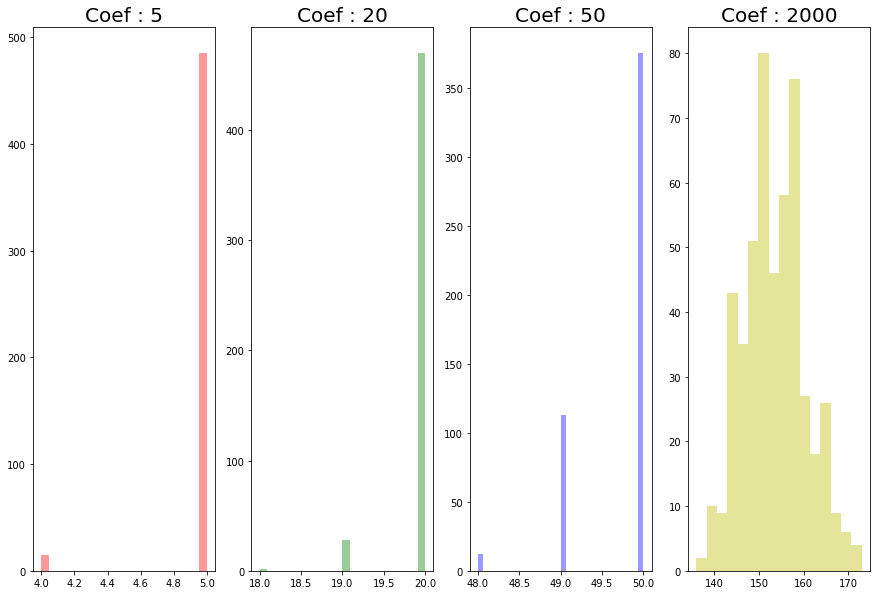

In [235]:
f ,ax = plt.subplots(1,4, figsize=(15,10))
axx = ax.flatten()
DoF   = [5 , 20 , 50 , 2000]
color = ["r","g","b" , "y"]
for dof , ax2 , col in zip(DoF , axx , color ) :
    sns.distplot(OutCome.loc[OutCome.DOF == dof,"Coef"].values , 
                 kde= False , hist =True , ax = ax2 , hist_kws ={"color" : col})
    ax2.set_title( "Coef : {}".format(dof) , fontsize= 20)
plt.show()

## Part-3

$x_i \sim U(-1,1)$ <br>
$y_i = 0 - x_i + x_i^2 - x_i^3 +...+ x_i^{10} + \epsilon_i$ <br>
$y_i = \sum_{j=1}^{10} (-1)^j x_i^j+\epsilon_i$ <br>
$h(x,\xi) 
= (x-\xi)^3 
\begin{cases}
(x-\xi)^3 , & \mbox{if }\mbox{ x > $\xi$ } \\
0 , & \mbox{otherwise}
\end{cases} $


In [155]:
X = np.random.uniform(low = -1.0 , high =1.0 ,size = 100)
X.sort()
train_eps = np.random.normal(loc = 0.0 , scale = 1, size = 100)

In [208]:
def cubic_data(a , xi) :
    out = np.concatenate((a,a**2, a**3, 
                          np.maximum((a-xi[0])**3,0) , 
                          np.maximum((a-xi[1])**3,0) ,
                          np.maximum((a-xi[2])**3,0) ,np.maximum((a-xi[3])**3,0) ),axis = 1)
    return out

def plotting(sample_n , ax) :
    X = np.random.uniform(low = -1.0 , high =1.0 ,size = sample_n)
    X.sort()
    train_eps = np.random.normal(loc = 0.0 , scale = 2 , size = sample_n)
    y = 0
    for i in np.arange(1, 11) :
        if i % 2 == 0 :
            a = 2.0
        else :
            a = -2.0
        y += (-1)**i * a * np.sin(4*X)**i
    true_y = y + train_eps 
    model = make_pipeline(PolynomialFeatures(10), LinearRegression())
    model.fit(X[:,np.newaxis], true_y[:,np.newaxis])
    poly_pred = model.predict(X[:,np.newaxis])
    xi = np.percentile(X, [20, 40, 60, 80])
    a = X[:,np.newaxis]
    data4cubic = cubic_data(a , xi)
    lm = LinearRegression()
    lm.fit(data4cubic , true_y)
    cubic_pred = lm.predict(data4cubic)
    ax.scatter(X , true_y)
    ax.plot(X, y , label ="true")
    ax.plot(X, poly_pred, label = "polynomial")
    ax.plot(X, cubic_pred , label = "cubic spline")
    ax.legend()

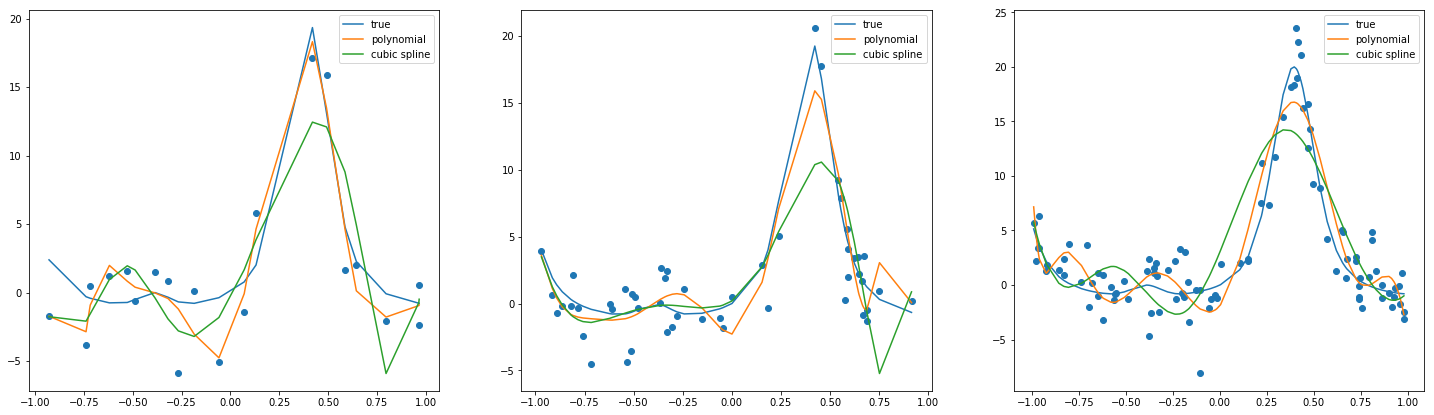

In [209]:
fig, ax = plt.subplots(1,3 ,figsize = (25,7))
axx = ax.flatten()
sample_nn = [20 , 50 ,100]
for n , i in zip(sample_nn , axx) : 
    plotting(n , i) 
plt.show()